# V(D)J analysis

In [1]:
import dandelion as ddl
import scanpy as sc
import warnings
import os

warnings.filterwarnings('ignore')
sc.settings.set_figure_params(dpi=80)

Let's run through some of what Dandelion can do in terms of analysis. In order to kickstart this tutorial, we prepared GEX and V(D)J objects with four demo 10X samples parsed for your convenience. You can download them from the ftp site as per below or from this [demo repo](https://github.com/zktuong/dandelion-demo-files). The GEX has had some basic Scanpy analysis performed on it, all the way up to making a UMAP and calling Leiden clusters. The VDJ is just four calls of `ddl.read_10x_airr()`, with the individual objects saved to a list, which was then passed to `ddl.concat()` to get a combined Dandelion object. No analysis was done on this combined object.

There's a notebook included at the end of the quickstart tutorial that shows exactly how this was done. The Dandelion import and concatenation outlined above is likely of the most interest.

In [2]:
if not os.path.exists("demo-gex.h5ad"):
    os.system("wget ftp://ftp.sanger.ac.uk/pub/users/kp9/demo-gex.h5ad")

if not os.path.exists("demo-vdj.h5ddl"):
    os.system("wget ftp://ftp.sanger.ac.uk/pub/users/kp9/demo-vdj.h5ddl")

Let's import the objects. Dandelion's `h5ddl` files can be read via `ddl.read_h5ddl()`.

In [3]:
adata = sc.read("demo-gex.h5ad")
vdj = ddl.read_h5ddl("demo-vdj.h5ddl")

At this point you're probably wondering why there's a separate Dandelion object. The reason is AIRR compliance. Some of the AIRR columns have more complex typing than what Scanpy can currently support within its objects. However, it's quite straightforward to link up a Scanpy object with a Dandelion one.

In [4]:
vdj, adata = ddl.pp.check_contigs(vdj, adata)

Preparing data: 6490it [00:02, 2570.75it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 3158/3158 [00:18<00:00, 169.82it/s]


This filters the contigs and synchronises relevant information between the objects. Once linked up like this, any new information can be copied over from the Dandelion object via `ddl.tl.transfer()`.

For now, let's take a look at the chain status (as gotten from the Dandelion object) and known BCR marker expression.

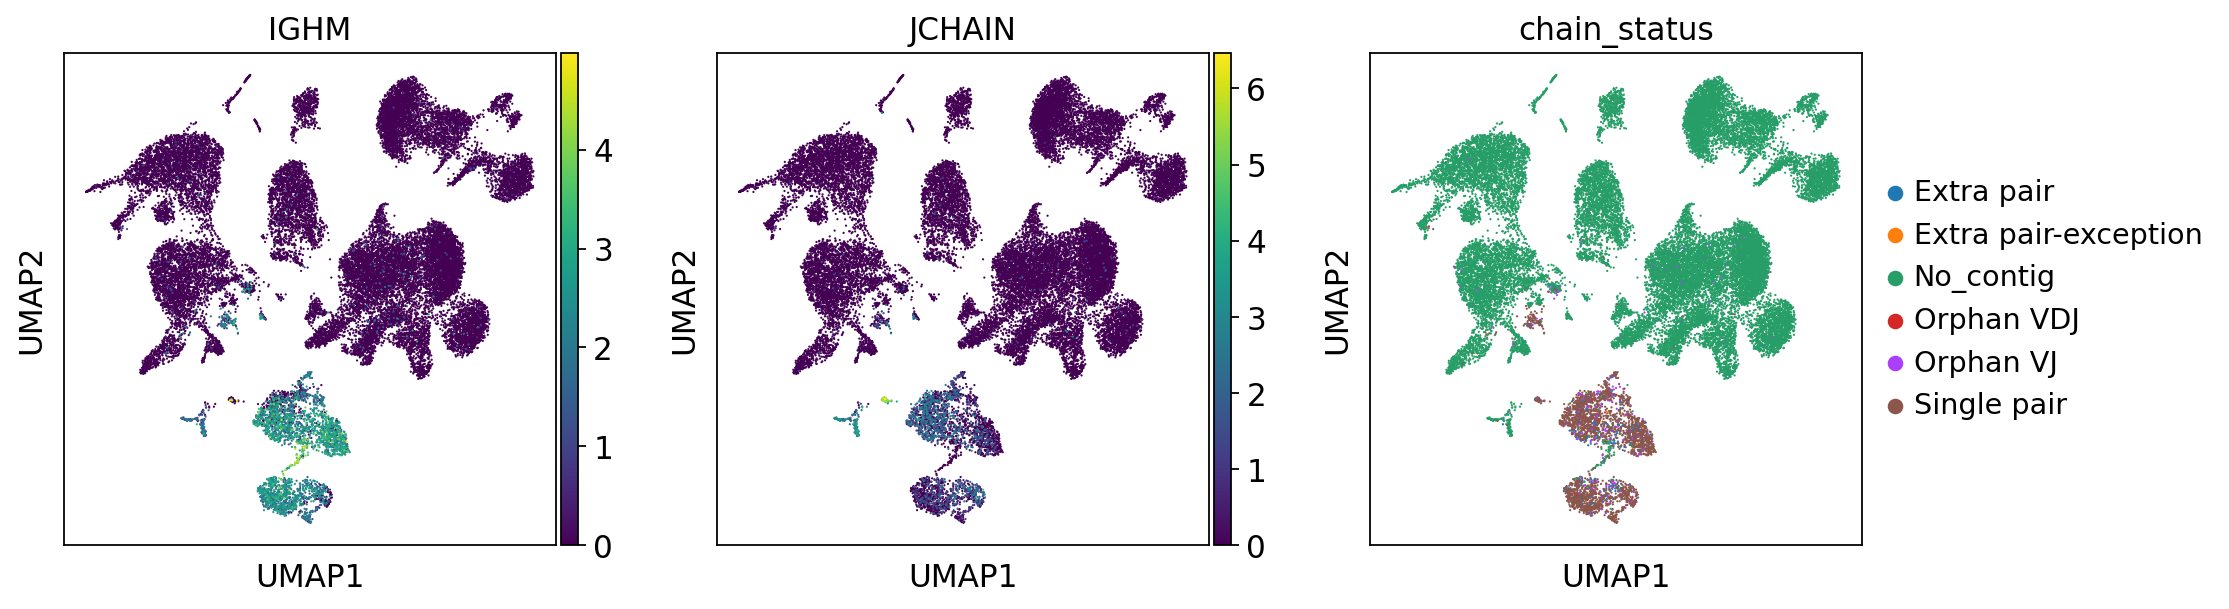

In [5]:
sc.pl.umap(adata, color=['IGHM', 'JCHAIN', 'chain_status'])

Under the hood, the Dandelion object is essentially two data frames. `.data` holds the AIRR-compliant contig space table, while `.metadata` is an `.obs` equivalent that parses the contig information to a cell level and can be easily integrated with a Scanpy object. There are also `ddl.to_scirpy()` and `ddl.from_scirpy()` for interoperability with Scirpy, as explored in a notebook in the extended tutorial.

The thing you're most likely to find yourself doing manually with the Dandelion object is modifying cell names to match your GEX naming convention. The cell names can be found in `.data.cell_id`, change those however you see fit and then call `ddl.utl.update_metadata(vdj)` to regenerate the per-cell `.obs` equivalent.

```
vdj.data.cell_id = [result of modification procedure on existing vdj.data.cell_id]
ddl.utl.update_metadata(vdj)
```

In [6]:
vdj

Dandelion class object with n_obs = 3092 and n_contigs = 7340
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'duplicate_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_bla

Now that we've got the gist of basic handling of the Dandelion object, let's use it for some analysis!

A core element of V(D)J analysis is clonotype calling, roughly equivalent to clustering cells in GEX processing. Dandelion requires the clones it calls to have identical V and J genes, along with no more than 15% mismatches in the CDR3 sequences ([common practice](https://royalsocietypublishing.org/doi/10.1098/rstb.2014.0239) in BCR analysis).

In [7]:
ddl.tl.find_clones(vdj)

Finding clones based on B cell VDJ chains : 100%|██████████| 256/256 [00:00<00:00, 1984.95it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 2817/2817 [00:00<00:00, 284166.39it/s]


We can compute a graph based on Levenshtein distance of the complete contig sequence. A NetworkX representation of it is now saved in `vdj.graph`.

In [8]:
ddl.tl.generate_network(vdj)

Setting up data: 6229it [00:02, 2834.04it/s]
Linking edges : 100%|██████████| 2722/2722 [00:00<00:00, 18152.40it/s]


Since we now know what our clonotype calls are, we can quantify clonal expansion. It's possible to cap this at a desired maximum clonotype size.

In [9]:
ddl.tl.clone_size(vdj)
ddl.tl.clone_size(vdj, max_size = 3)

Now that our Dandelion object has analysis information inside it, we can copy it over to the Scanpy object to have access to it there. The graph gets turned into the Scanpy standard forms of `.obsp['vdj_distances']` and `.obsp['vdj_connectivites']` for potential downstream use.

In [10]:
ddl.tl.transfer(adata, vdj)

Let's take a look at what we made!

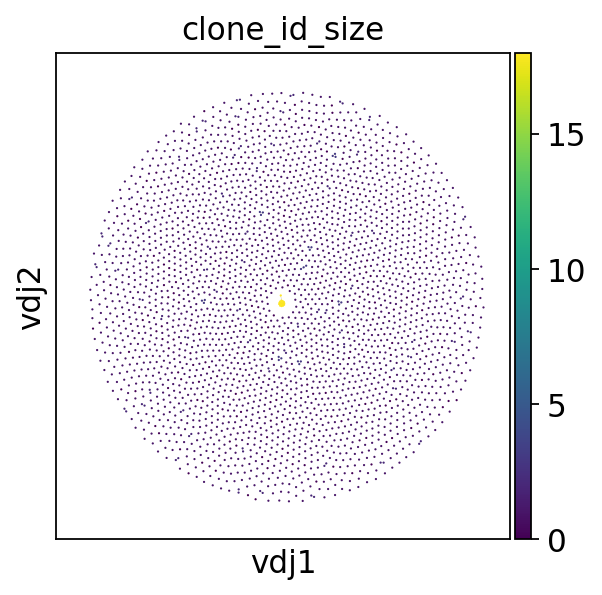

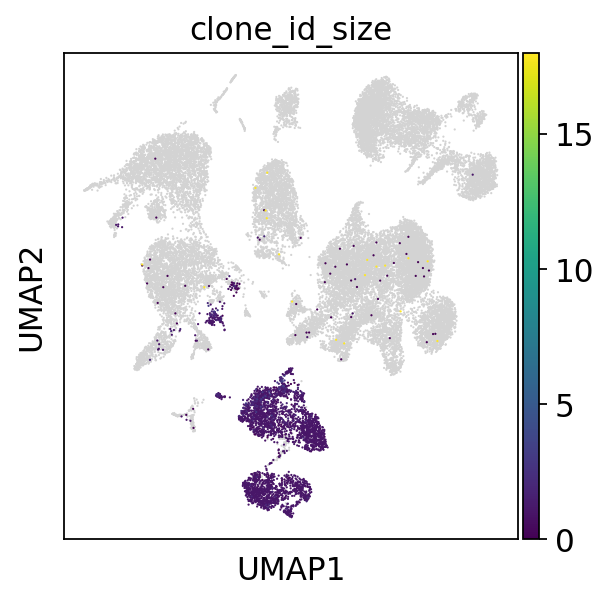

In [11]:
ddl.pl.clone_network(adata, color='clone_id_size')
sc.pl.umap(adata, color='clone_id_size')

Wait, why are we seeing some clone size 0 in the plots? Orphan chains.

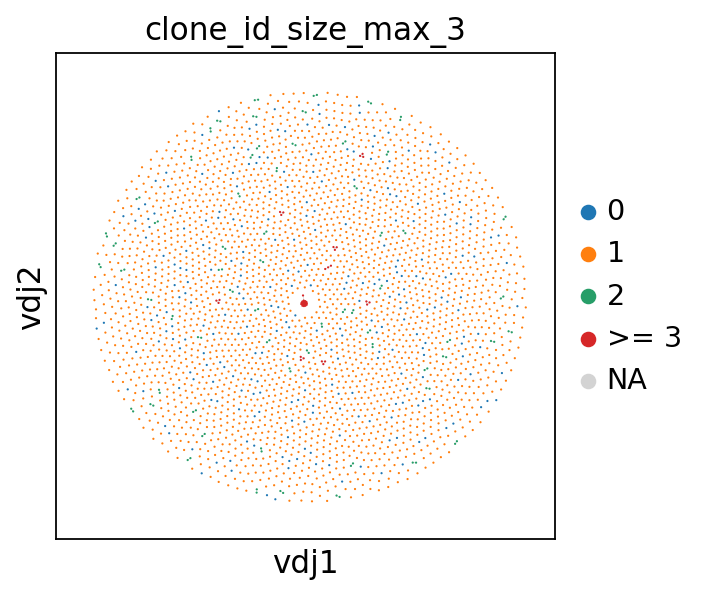

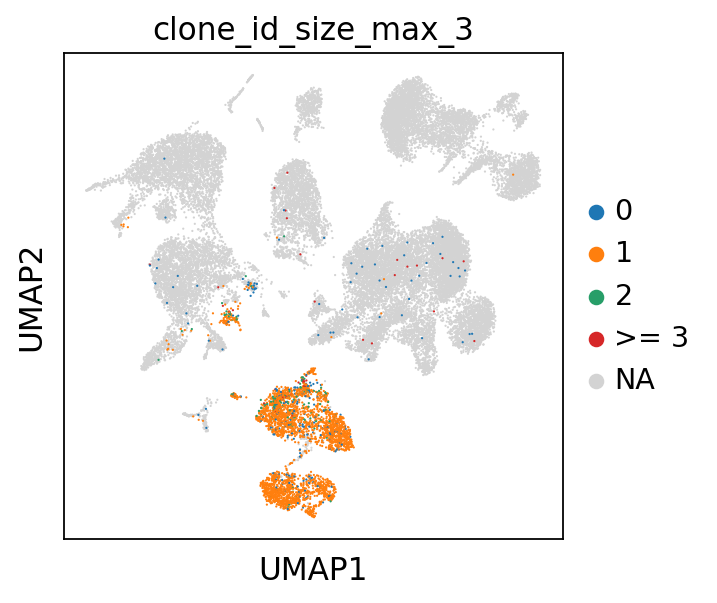

In [12]:
ddl.pl.clone_network(adata, color='clone_id_size_max_3')
sc.pl.umap(adata, color='clone_id_size_max_3')

Dandelion comes with a number of plotting functions for your convenience. However, those functions tend to operate best without the Scanpy plotting defaults in place. You can reset Matplotlib's configuration prior to using them.

In [13]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

We've got bar plots.

(<Figure size 800x300 with 1 Axes>,
 <AxesSubplot:title={'center':'v call genotyped VDJ usage'}, ylabel='proportion'>)

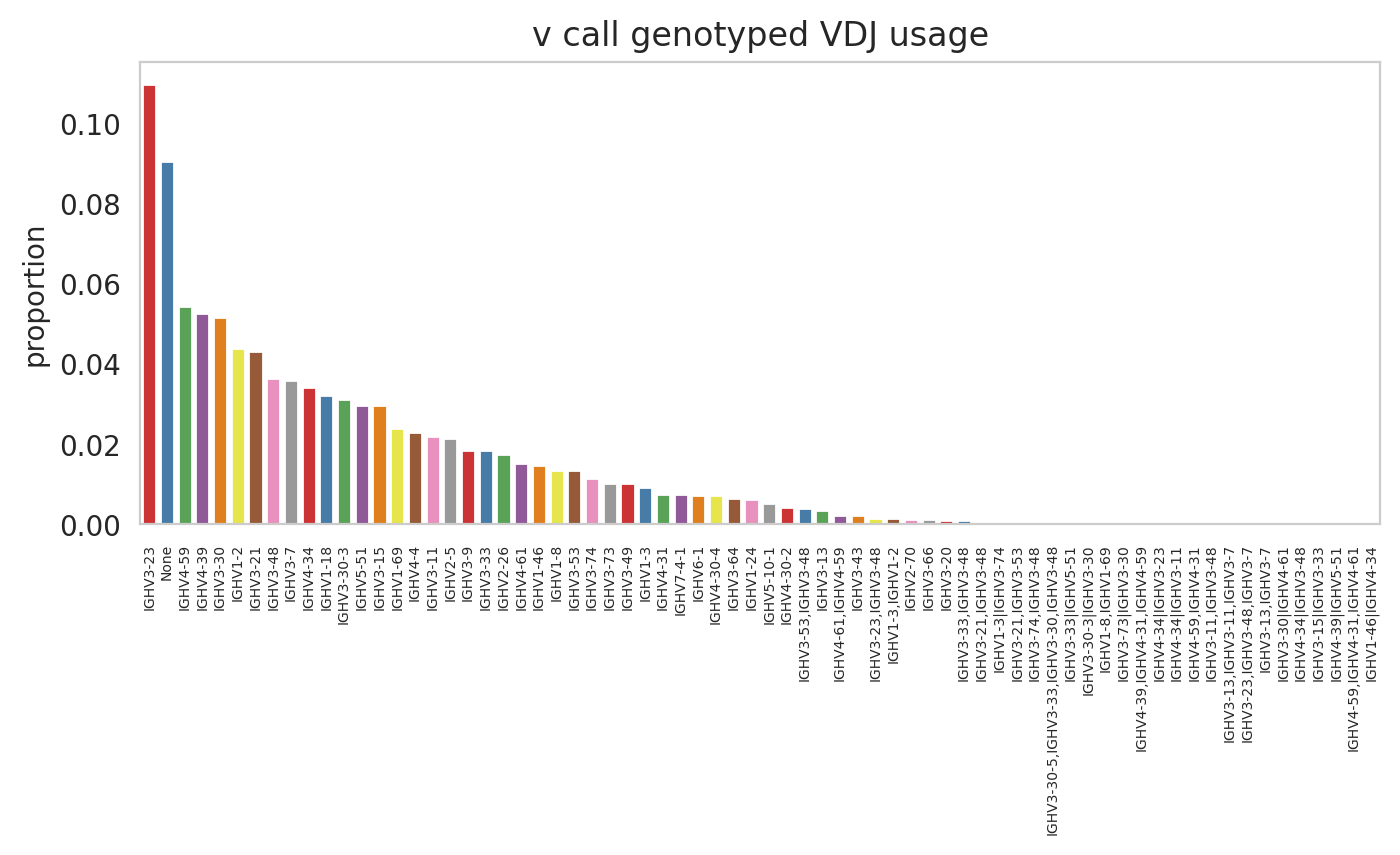

In [14]:
ddl.pl.barplot(vdj[vdj.metadata.isotype_status != 'Multi'], # remove multi from the plots
               color = 'v_call_genotyped_VDJ', xtick_fontsize = 5)

All of the plotting functions have a number of parameters that can be fiddled with for desired visualisation outcomes. For example, let's disable automatic descending sorting, show counts rather than proportions, and change the palette.

(<Figure size 800x300 with 1 Axes>,
 <AxesSubplot:title={'center':'v call genotyped VDJ usage'}, ylabel='count'>)

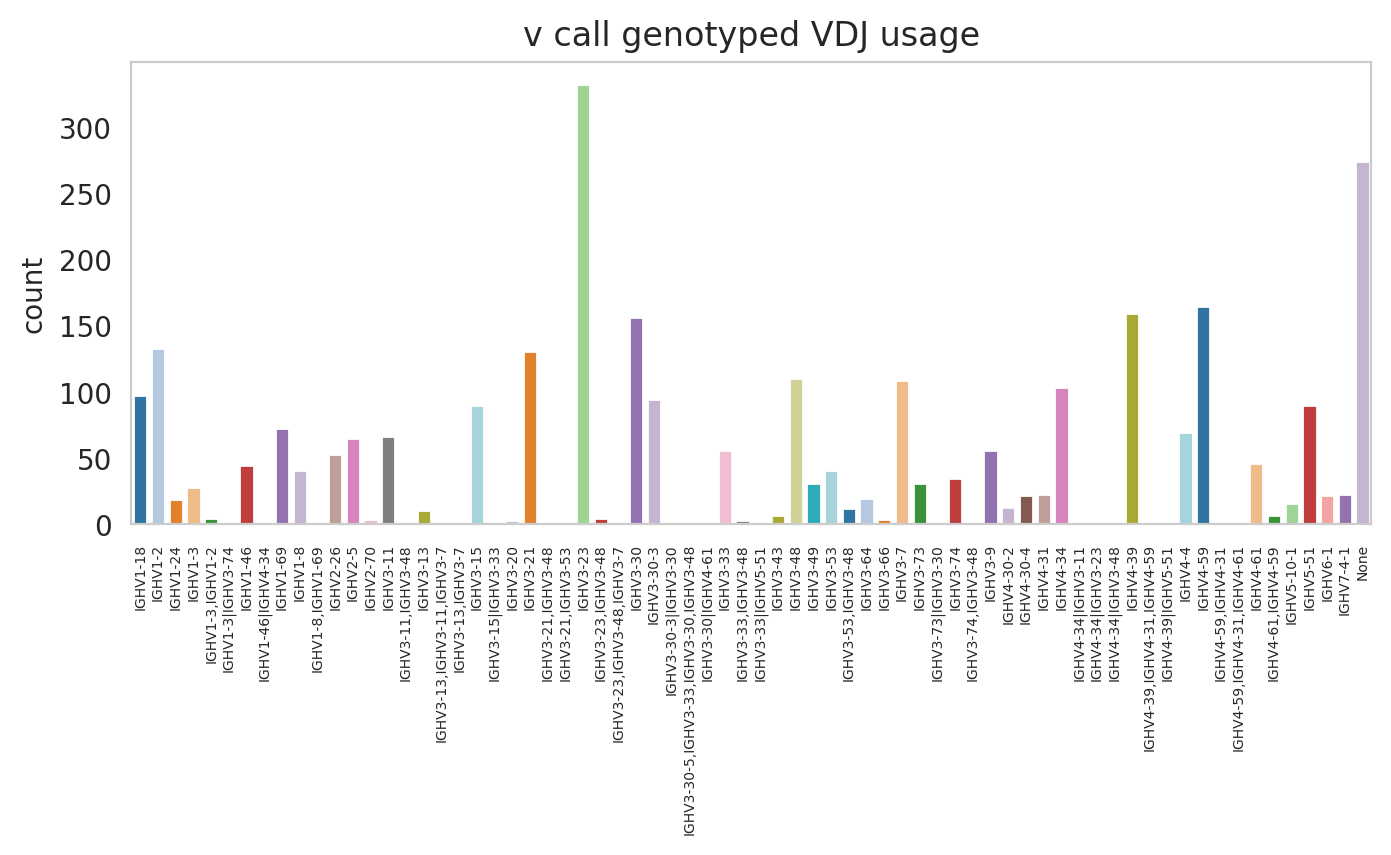

In [15]:
ddl.pl.barplot(vdj[vdj.metadata.isotype_status != 'Multi'],
               color = 'v_call_genotyped_VDJ',
               normalize = False,
               sort_descending = None,
               palette = 'tab20',
               xtick_fontsize = 5
              )

We've got stacked bar plots.

(<Figure size 400x300 with 1 Axes>,
 <AxesSubplot:title={'center':'multiple stacked bar plot : isotype status usage'}, ylabel='count'>)

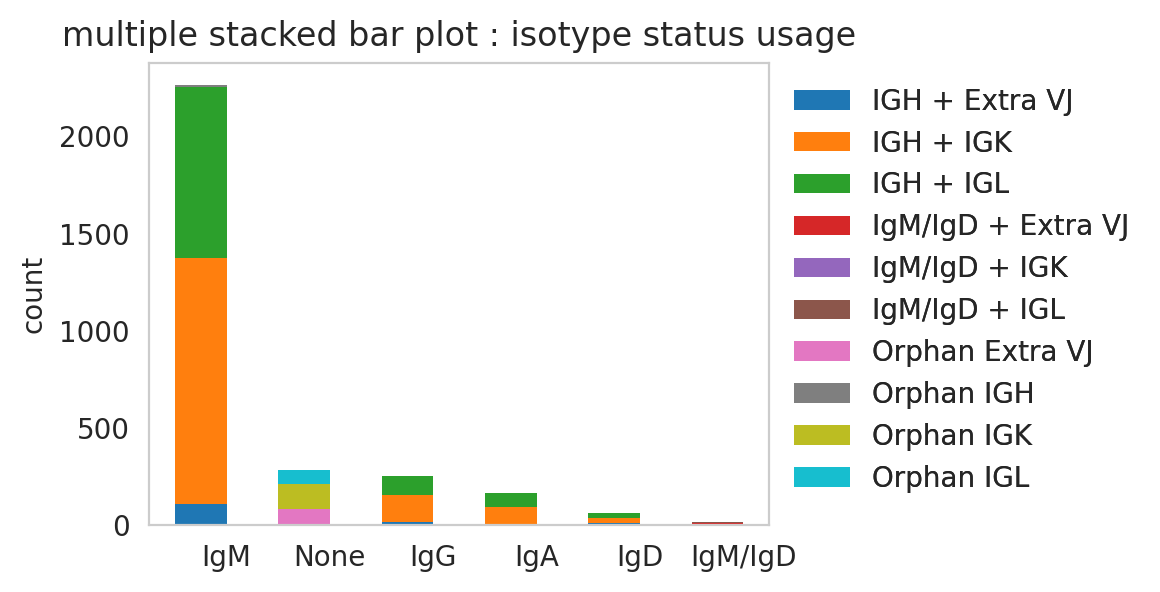

In [16]:
ddl.pl.stackedbarplot(vdj[vdj.metadata.isotype_status != 'Multi'],
                      color = 'isotype_status',
                      groupby = 'locus_status',
                      xtick_rotation = 0,
                      figsize = (4,3)
                     )

These can be normalised to add up to 1 for each column.

(<Figure size 800x300 with 1 Axes>,
 <AxesSubplot:title={'center':'multiple stacked bar plot : v call genotyped VDJ usage'}, ylabel='proportion'>)

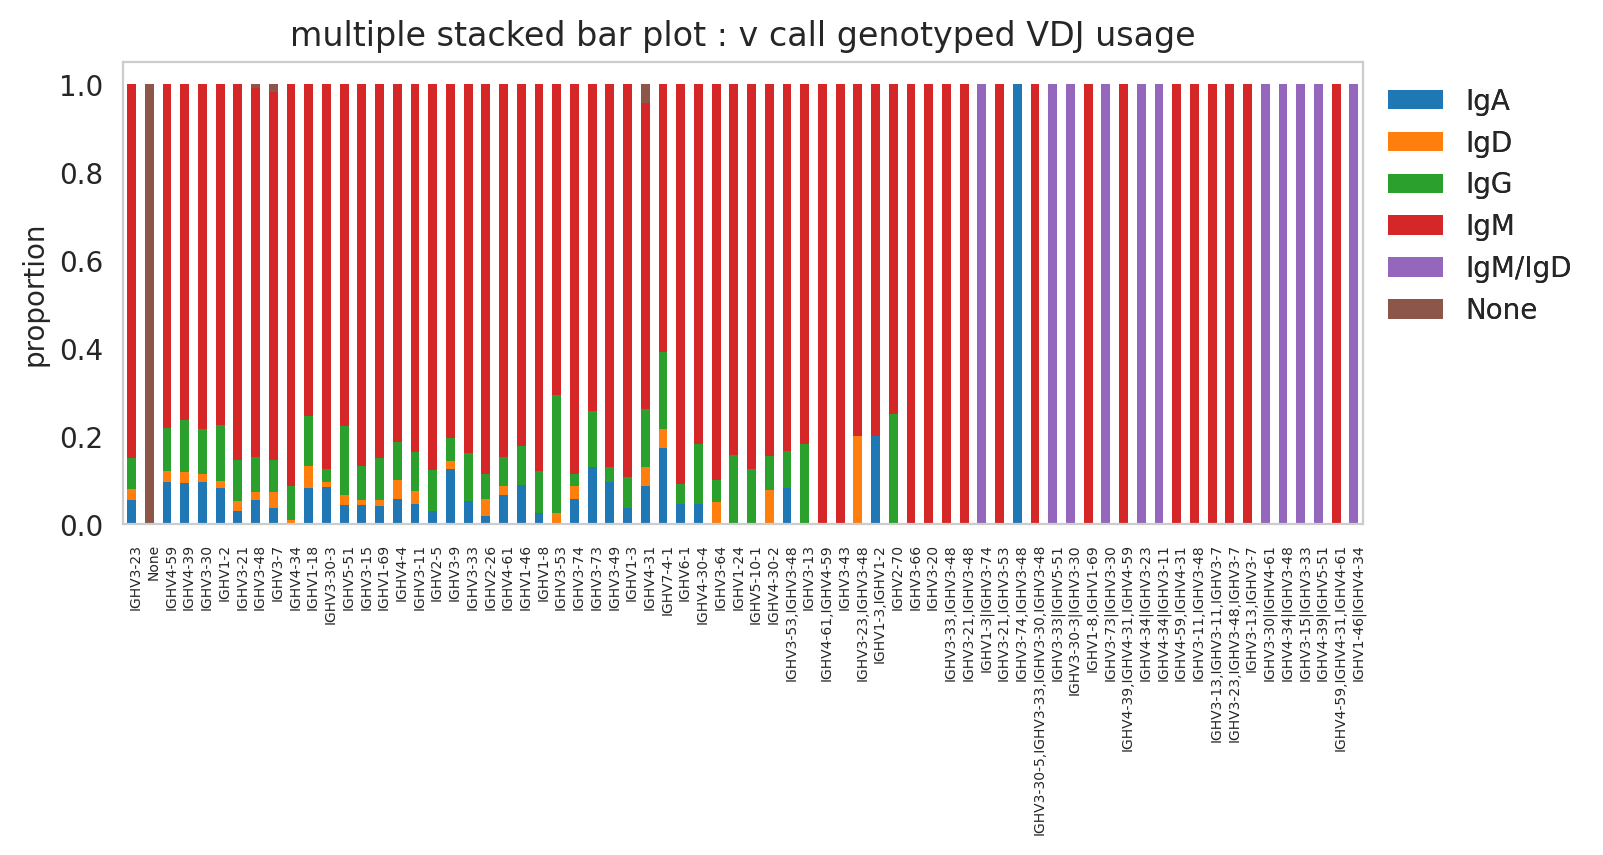

In [17]:
ddl.pl.stackedbarplot(vdj[vdj.metadata.isotype_status != 'Multi'],
                      color = 'v_call_genotyped_VDJ',
                      groupby = 'isotype_status',
                      normalize = True,
                      xtick_fontsize = 5
                     )

We've also got a spectratype plot, which shows the distribution of the CDR3 length for the various contigs.

(<Figure size 500x300 with 1 Axes>,
 <AxesSubplot:xlabel='junction_length', ylabel='count'>)

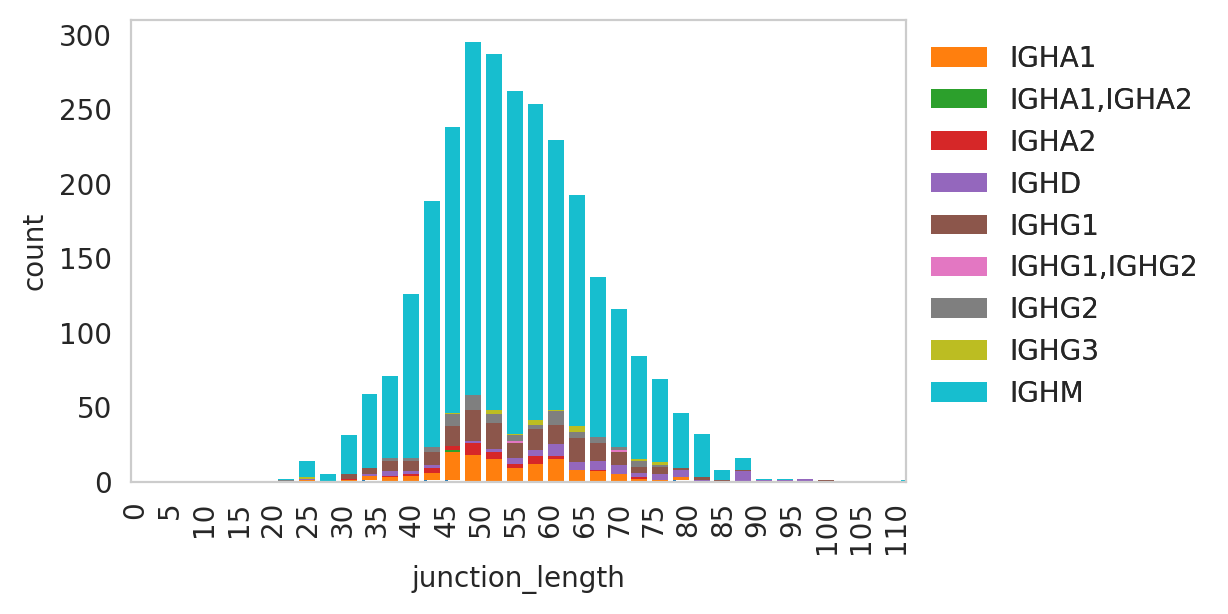

In [18]:
ddl.pl.spectratype(vdj[vdj.metadata.isotype_status != 'Multi'],
                   color = 'junction_length',
                   groupby = 'c_call',
                   locus='IGH',
                   width = 2.3
                  )

Another common V(D)J analysis request is to examine the distribution of shared clonotypes between cells of different metadata groups. Dandelion can do this as a circos plot.

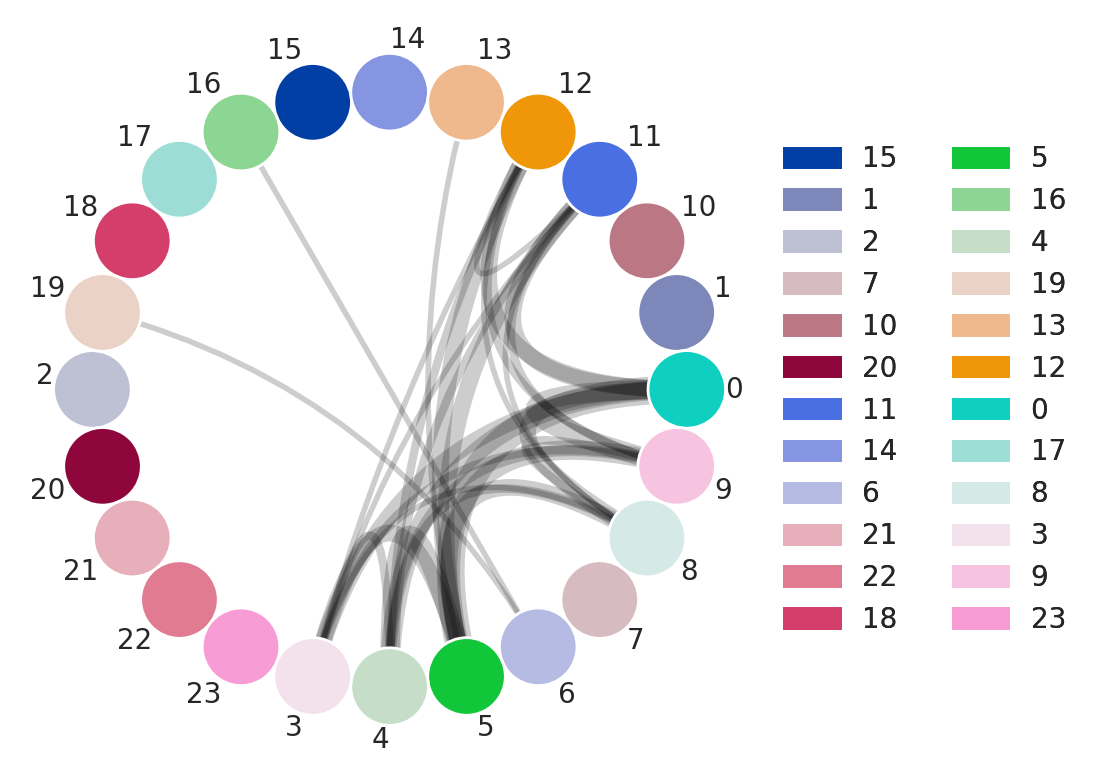

In [19]:
ddl.tl.clone_overlap(adata,
                     groupby = 'leiden',
                     colorby = 'leiden',
                     weighted_overlap = True
                    )
ddl.pl.clone_overlap(adata,
                     groupby = 'leiden',
                     colorby = 'leiden',
                     weighted_overlap = True
                    )

There's also a heatmap on offer.

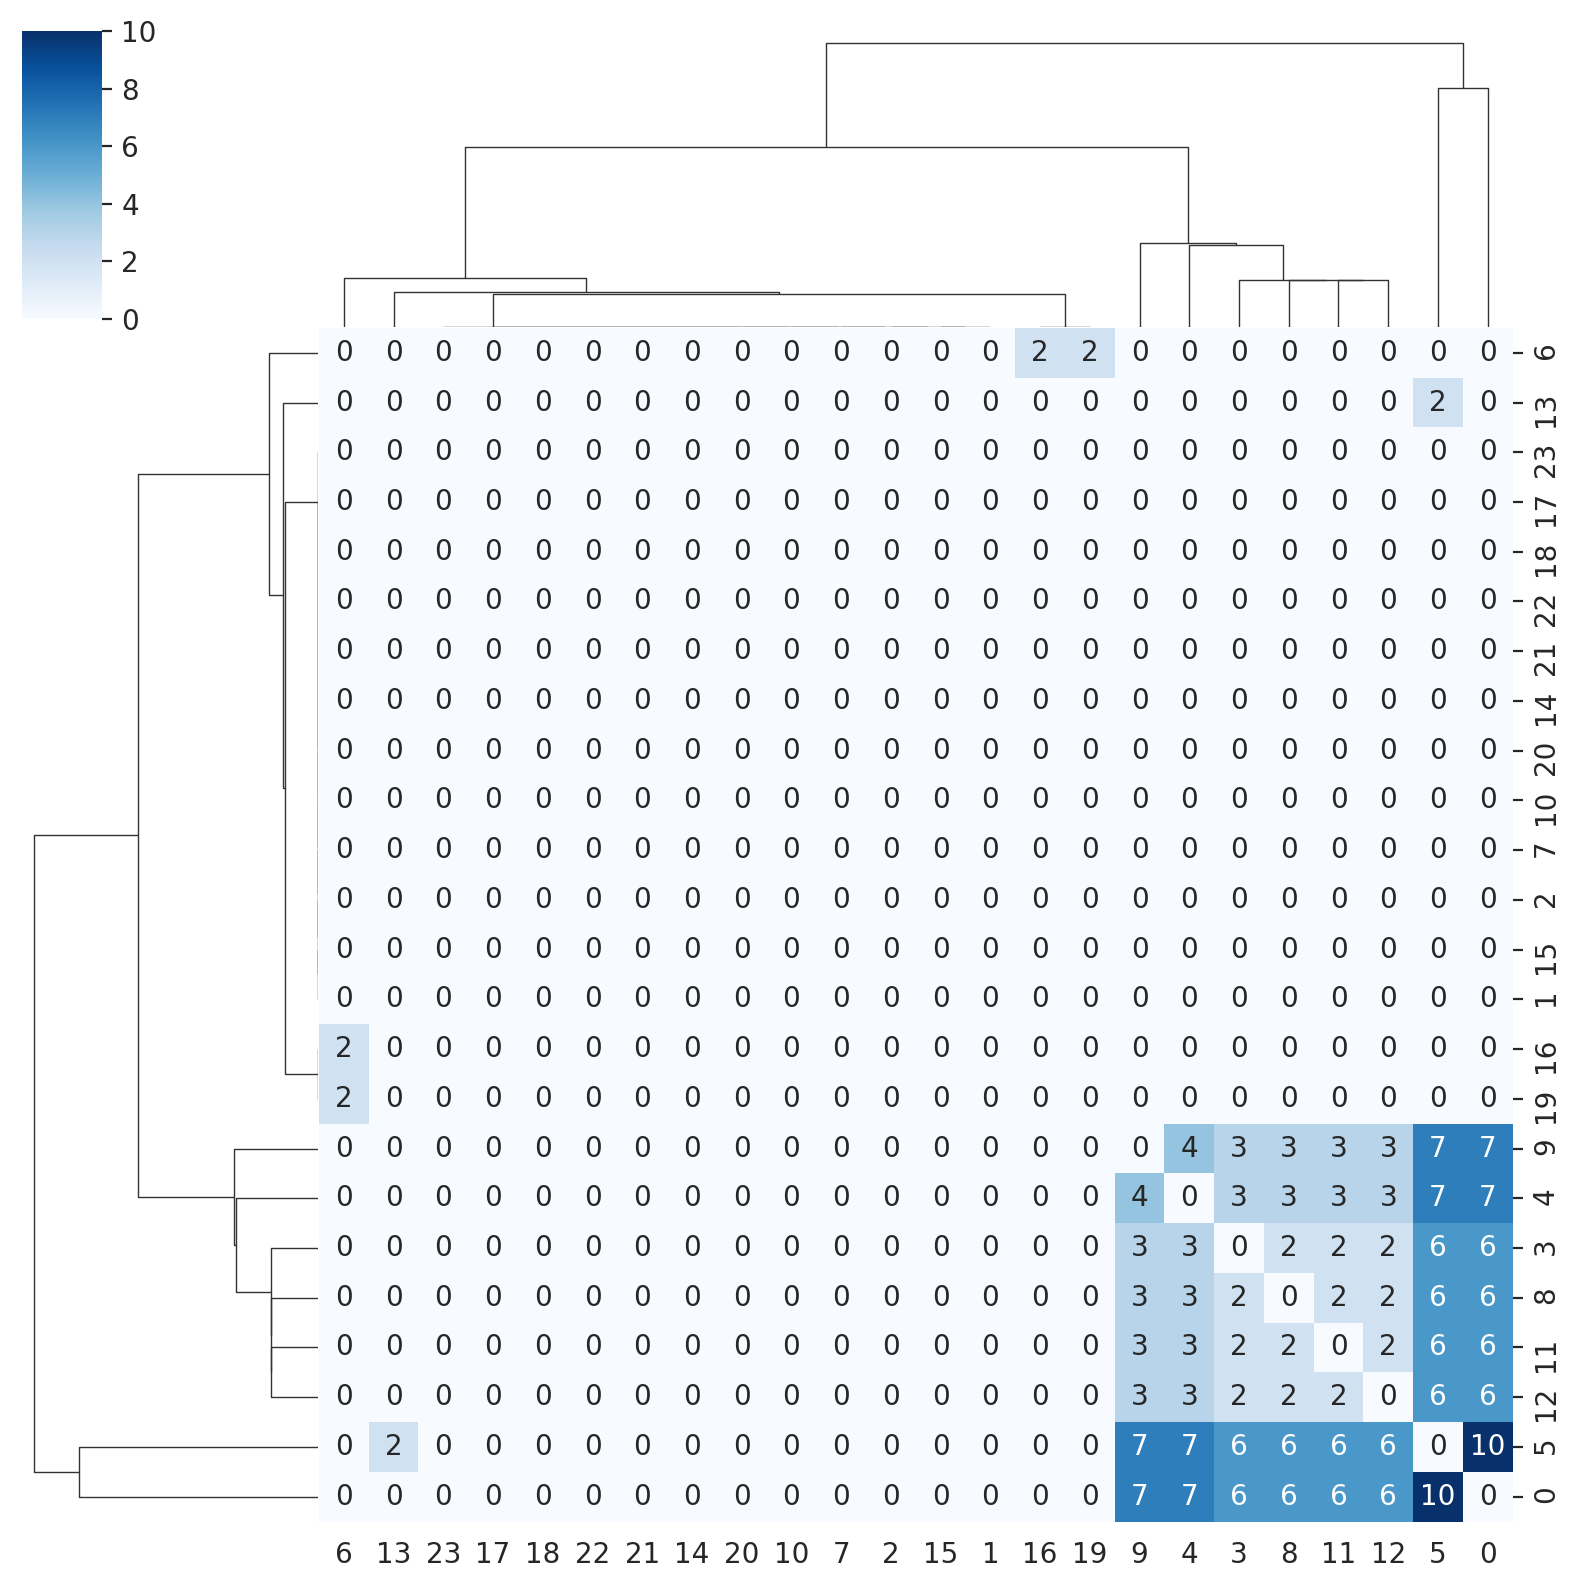

In [20]:
ddl.pl.clone_overlap(adata,
                     groupby = 'leiden',
                     colorby = 'leiden',
                     weighted_overlap = True, as_heatmap = True,
                     # seaborn clustermap kwargs
                     cmap = 'Blues', annot = True, figsize=(8,8), annot_kws={"size": 10})

Save the objects, like so.

In [21]:
adata.write("demo-gex-processed.h5ad")
vdj.write("demo-vdj-processed.h5ddl")